This notebook serves to explore various methods of detecting textures in images. The emphasis here is on finding representations that separate a texture from its background: The classifier used is included simply to provide a measure of representation quality.

Image spec.:
    - Do not include axes.
    - (15, 5) plots where necessary (title in Illustrator).
    - Grayscale single-channel images.

#### Introduction

For the purposes of this document, texture can be characterised as a distinct configuration of the following factors:
    - Intensity
    - Periodicity
    - Non-periodic variation (i.e. randomness)
    - Orientation
    - Direction
    - Size

Additional information about a texture may also be derived from:
    - Position relative to the camera.
    - Orientation relative to the camera.
    - The texture's background.
    - The transition between texture and background.
    
Before examining specific filtering methods, we will briefly list what methods are available for texture analysis, along with their motivation.

*Peak-counting*
    - Suppress local non-maximum intensities.
    - Apply a threshold.
    - Count the peaks in the vicinity.
    
*Autocorrelation*
    - Compute correlations between pixel intensities across some period at a given orientation (e.g. every other pixel, every 5 pixels etc.).
    
*Fourier analysis*
    - Map the image from the intensity domain to the spatial frequency domain
    
*Co-occurence matrices, with summary statistics*
    - Compute the relative frequency with which two distinct intensities reccur at a given orientation and radial distance.
    - Summary statistics - energy, entropy, inertia, correlation, local homogeneity.
    
*Texture energy via Laws' filters*
    - Begin with three kernels designed to extract edges, spots, and local intensity.
    - Take these kernels' outer products to derive a set of masks.
    - Convolve these masks with the images, then smooth (why smooth?).
    - Square the resulting smoothed values to obtain energy measures.
    - Combine the various energy measurements to produce features useful for classification.
    
*Texture energy via eigenfilters*
    - Compute the covariance matrix over a texture region.
    - Obtain the eigenvectors of this covariance matrix.
    - Use these eigenvectors as kernels with which to extract energy measures.
    
*Local rank correlation*

*Forced-choice method*

In [1]:
#from skimage.exposure import equalize_adapthist
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
# Display the image we'll be working with
from scipy.misc import imread

img_dir = "./Data/170812_RustAnalysis/"
sav_dir = "./Results/012_TextureAnalysis/"
raw_image = imread(img_dir + '001.png', mode = 'RGB').astype(np.float32)/255
raw_mask  = imread(img_dir + '006.png')
raw_mask  = np.logical_and(raw_mask[:,:,0] < 20, raw_mask[:, :, 1] > 240)
raw_mask  = (resize(raw_mask, raw_image.shape, mode = 'reflect') > 0.1)[:,:,0].astype(np.float32)

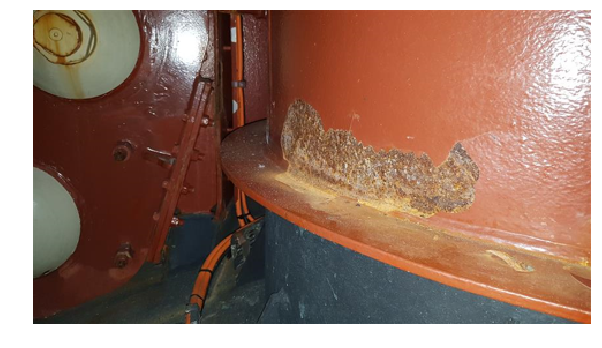

In [3]:
plt.figure(figsize = (10, 6))
plt.imshow(raw_image)
plt.axis('off');

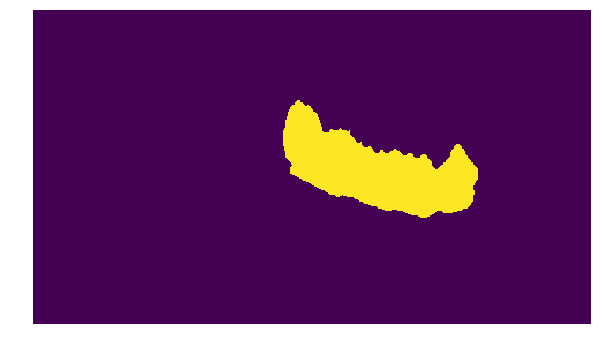

In [4]:
plt.figure(figsize = (10, 6))
plt.imshow(raw_mask)
plt.axis('off');

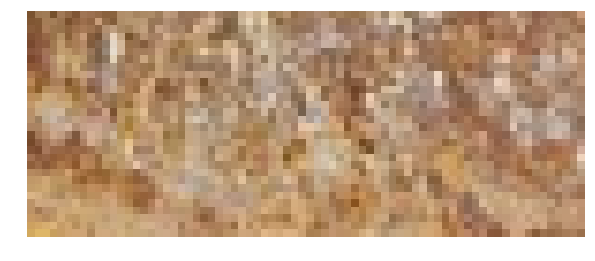

In [6]:
# Display a patch of the rust
rust_element = equalized_image[130:160, 260:-150]
plt.figure(figsize = (10, 6))
plt.imshow(rust_element)
plt.axis('off');

#### TF Graph for a convolutional linear projection followed by softmax

This model can be understood as running a logistic regression classifier against patches of the image, with the response for each patch corresponding to the central pixel's rust/not-rust status.

In [88]:
import tensorflow as tf

class convolutional_softmax_classifier:
    
    def __init__(self, kernel_size, in_channels, learning_rate = 0.05):
        
        self.graph = tf.Graph()

        with self.graph.as_default():
            with tf.name_scope('Inputs'):
                self.input_image = tf.placeholder(tf.float32, [None, None, None, in_channels]) # n-channel
                self.input_mask  = tf.placeholder(tf.float32, [None, None, None]) # Single-channel

            with tf.name_scope('Variables'):
                self.weights     = tf.Variable(tf.truncated_normal(shape  = [kernel_size, kernel_size, in_channels, 2],
                                                                  mean   = 0.,
                                                                  stddev = 1.))
                self.biases      = tf.Variable(tf.zeros(shape = [1, 1, 1, 2]))

            with tf.name_scope('Model'):
                with tf.name_scope('Standardization'):
                    standardized_input = self.input_image - 0.5
                    standardized_mask  = self.input_mask/tf.reduce_max(self.input_mask)

                with tf.name_scope('LinearProjection'):
                    logits      = tf.nn.conv2d(standardized_input, self.weights,
                                               strides = [1, 1, 1, 1], padding = 'SAME') + self.biases
                    self.predictions = tf.nn.softmax(logits, dim = -1)

                with tf.name_scope('Loss'):
                    ohe_logits  = tf.reshape(logits, shape = [-1, 2])
                    ohe_mask    = tf.reshape(standardized_mask, shape = [-1])
                    ohe_labels  = tf.stack([ohe_mask, 1 - ohe_mask], axis = -1)
                    self.loss   = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = ohe_labels,
                                                                                         logits = ohe_logits))

            with tf.name_scope('Optimization'):
                self.optimize    = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.loss)

### Reference model - RGB classifier

In [8]:
ksize = 5
training_steps = 5001

rgb_c = convolutional_softmax_classifier(ksize, in_channels = 3)

with tf.Session(graph = rgb_c.graph) as session:
    session.run(tf.global_variables_initializer())
    fd        = {rgb_c.input_image : equalized_image[np.newaxis, :, :, :],
                 rgb_c.input_mask  : raw_mask[np.newaxis, :, :] }
    
    for step in range(training_steps):
        _, l = session.run([rgb_c.optimize, rgb_c.loss], feed_dict = fd)
        if step % 500 == 0:
            print('Loss at step {:^3d}: {:^5.2f}'.format(step, l))
            
    p_rgb = session.run(rgb_c.predictions, feed_dict = fd)

Loss at step  0 : 0.61 
Loss at step 500: 0.26 
Loss at step 1000: 0.24 
Loss at step 1500: 0.23 
Loss at step 2000: 0.23 
Loss at step 2500: 0.22 
Loss at step 3000: 0.22 
Loss at step 3500: 0.21 
Loss at step 4000: 0.21 
Loss at step 4500: 0.21 
Loss at step 5000: 0.21 


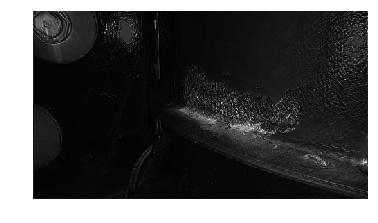

In [9]:
plt.imshow(p_rgb[0, :, :, 0], cmap = 'gray')
plt.axis('off');

### Eigenfilters

Our objective now is to compute the covariance matrix of this image patch. A problem is that we are working with a 20x20x3 patch, for which the corresponding covariance matrix contains 1.6 million elements. Our purpose in deriving the covariance matrix is to compute its eigenvectors (i.e. the principal components of the rust texel in intensity space).

We could conceivably move to a different colour space to reduce the number of elements (e.g. grayscale or a channel of HSL or RGB), however in doing this we would lose information that may be valuable. 

In [12]:
patch_size = 7
plt.style.use('ggplot');

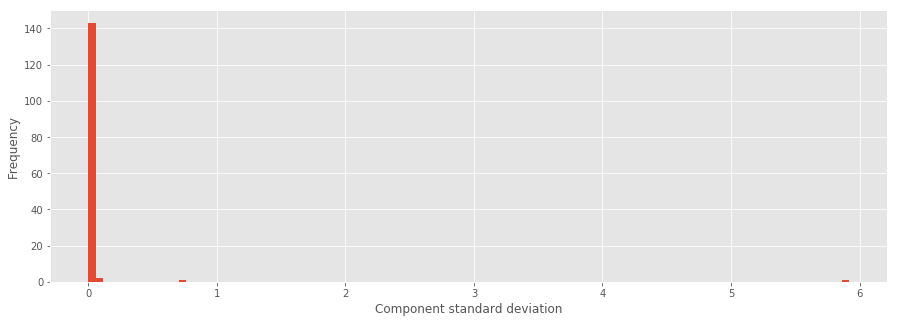

In [13]:
def get_eigen(image, patch_size = 7):
    patches    = [ image[i:i+patch_size, j:j + patch_size, :].flatten()
                   for i in range(image.shape[0] - patch_size)
                   for j in range(image.shape[1] - patch_size) ]
    patches    = np.stack(patches, axis = 0)

    C = np.cov(patches, rowvar = False)
    eigenvalues, principal_components = np.linalg.eig(C)
    return eigenvalues, principal_components

eigenvalues, principal_components = get_eigen(raw_image, patch_size = 7)
plt.figure(figsize = (15, 5))
plt.hist(eigenvalues, bins = 101); plt.xlabel('Component standard deviation'); plt.ylabel('Frequency');

We can see that most variation is confined to a plane, with many (145) other components pointing in directions with little variation.

In [100]:
from scipy.signal import convolve, gaussian

def apply_smoothing(image, ksize = 7):
    kernel_size = ksize
    n_std       = 3
    K           = np.tensordot(gaussian(kernel_size, std = kernel_size/n_std)[:, np.newaxis],
                               gaussian(kernel_size, std = kernel_size/n_std)[np.newaxis, :],
                               axes = [1, 0])
    return convolve(image, K, mode = 'same')

def apply_filters(image, filters):
    """
        Filters is a list of filter kernels to be convolved with an image.
        Returns a stack of image channels, with each channel corresponding to its respective filter.
    """
    return [convolve(image.astype(np.float32), f, mode = 'valid').squeeze() for f in filters]

n_filters  = 3
eigfilters = [principal_components[i].reshape([patch_size, patch_size, 3])
              for i in np.flip(eigenvalues.argsort(), axis = 0)[:n_filters]]

eigen_images = [np.pad(apply_smoothing(img, 1)**2, [[patch_size//2, patch_size//2]]*2, mode = 'reflect')
                   for img in apply_filters(raw_image, eigfilters)]

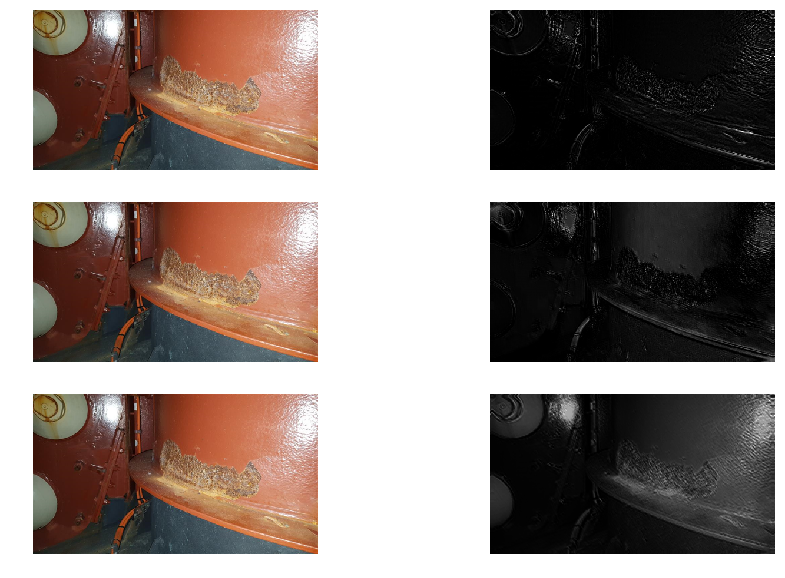

In [102]:
f, axs = plt.subplots(n_filters, 2, figsize = (15, 10))

for i, ax in enumerate(axs.flatten()):
    if i % 2 == 0:
        ax.imshow(raw_image)
        ax.axis('off');
    else:
        ax.imshow(eigen_images[i//2], cmap = 'gray')
        ax.axis('off');

In [104]:
eigfilter_input = np.stack(eigen_images, axis = -1)
eigfilter_input = eigfilter_input/np.std(eigfilter_input, axis = (0, 1))
eig_c = convolutional_softmax_classifier(5, in_channels = eigfilter_input.shape[-1])

with tf.Session(graph = eig_c.graph) as session:
    session.run(tf.global_variables_initializer())
    fd        = {eig_c.input_image : eigfilter_input[np.newaxis, :, :, :],
                 eig_c.input_mask  : raw_mask[np.newaxis, :, :] }
    
    for step in range(training_steps):
        _, l = session.run([eig_c.optimize, eig_c.loss], feed_dict = fd)
        if step % 500 == 0:
            print('Loss at step {:^3d}: {:^5.2f}'.format(step, l))
            
    p_eig = session.run(eig_c.predictions, feed_dict = fd)

Loss at step  0 : 5.00 
Loss at step 500: 0.42 
Loss at step 1000: 0.32 
Loss at step 1500: 0.27 
Loss at step 2000: 0.25 
Loss at step 2500: 0.23 
Loss at step 3000: 0.23 
Loss at step 3500: 0.23 
Loss at step 4000: 0.22 
Loss at step 4500: 0.22 
Loss at step 5000: 0.22 


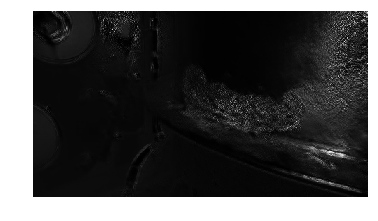

In [105]:
plt.imshow(p_eig[0, patch_size//2:-patch_size//2, patch_size//2:-patch_size//2, 0], cmap = 'gray')
plt.axis('off');

### Laws' filters

In [106]:
L5 = np.array([1, 4, 6, 4, 1])
E5 = np.array([-1, 2, 0, 2, 1])
S5 = np.array([1, 0, 2, 0, -1])
R5 = np.array([1, -4, 6, -4, 1])
W5 = np.array([-1, 2, 0, -2, 1])

Laws_filters = [np.tensordot(f1[:, np.newaxis], f2[np.newaxis, :], axes = [1, 0])
                for f1 in [L5, E5, S5, R5, W5]
                for f2 in [L5, E5, S5, R5, W5]]

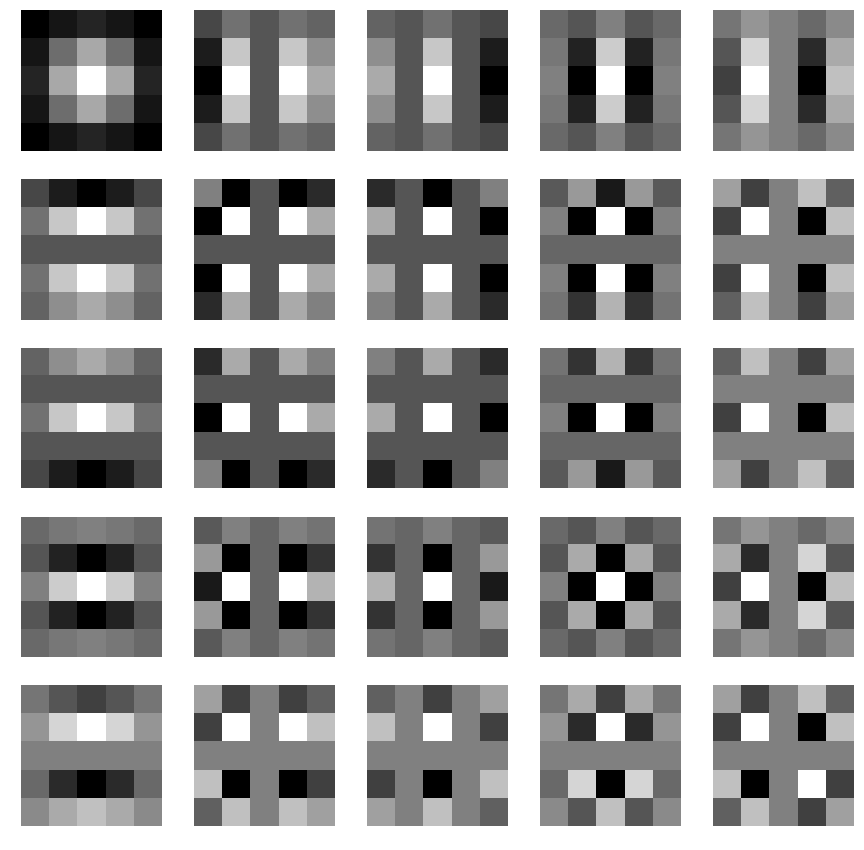

In [107]:
f, axs = plt.subplots(5, 5, figsize = (15, 15))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(Laws_filters[i], cmap = 'gray')
    ax.axis('off');

In [108]:
Laws_filters = [np.stack([f, f, f], axis = -1) for f in Laws_filters]

filtered_images = [np.pad(apply_smoothing(img)**2, [[patch_size//2, patch_size//2]]*2, mode = 'reflect')
                   for img in apply_filters(equalized_image, Laws_filters)]

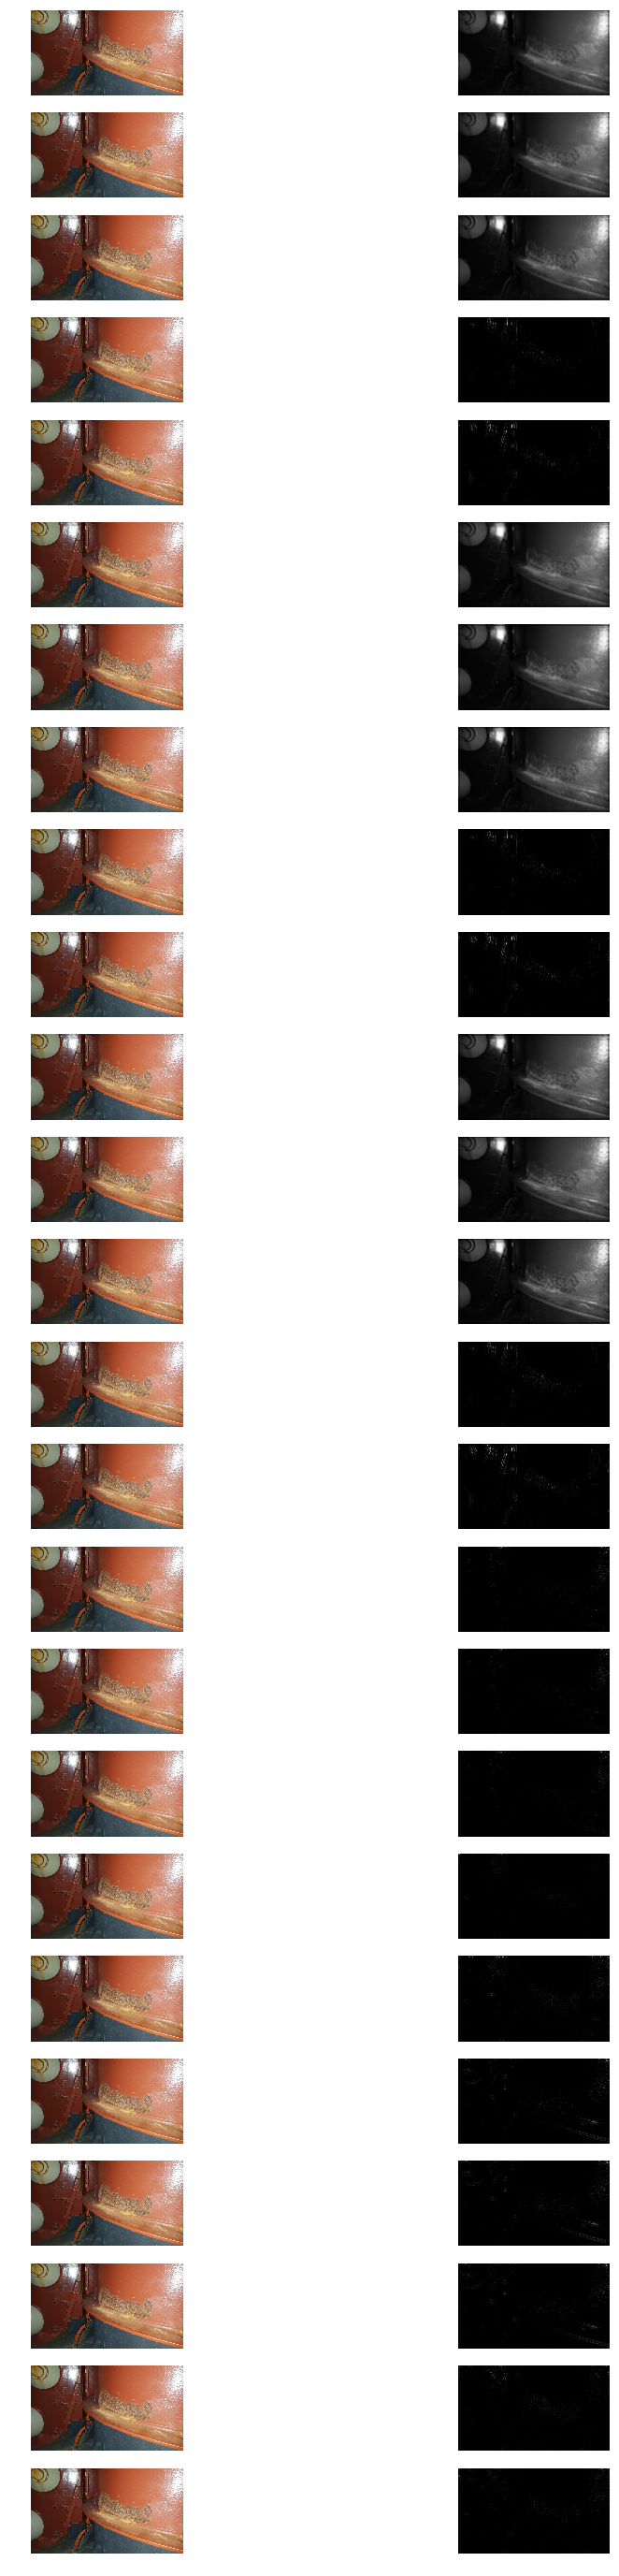

In [109]:
f, axs = plt.subplots(len(Laws_filters), 2, figsize = (15, 50))

for i, ax in enumerate(axs.flatten()):
    if i % 2 == 0:
        ax.imshow(equalized_image)
        ax.axis('off');
    else:
        ax.imshow(filtered_images[i//2], cmap = 'gray')
        ax.axis('off');

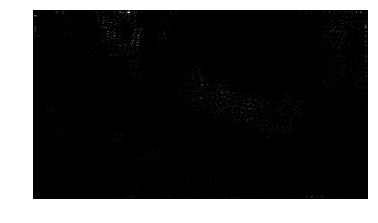

In [110]:
plt.imshow(filtered_images[-2], cmap = 'gray')
plt.axis('off');

### Colour Histograms

In [111]:
from skimage.color import convert_colorspace

In [112]:
hsv_image = convert_colorspace(raw_image, 'RGB', 'HSV')

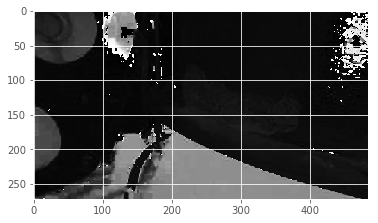

In [113]:
plt.imshow(hsv_image[:, :, 0], cmap = 'gray');

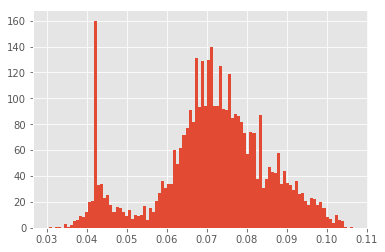

In [114]:
plt.hist(hsv_image[100:150,220:300,0].flatten(), bins = 100);

(0, 0.1)

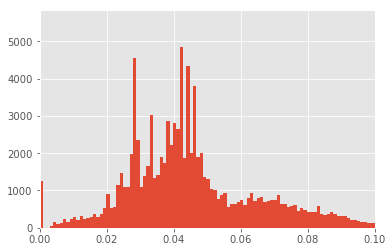

In [115]:
plt.hist(hsv_image[:,:,0].flatten(), bins = 1001);
plt.xlim(0, 0.1)

In [116]:
# Define a Gaussian centered on about 0.075
mu = 0.075
sd = 0.01

def dnorm(x, mu, sd):
    return np.exp(-0.5*(x - mu)**2/(sd**2))

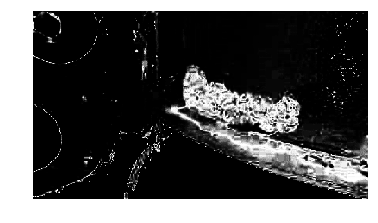

In [117]:
hue_filtered = dnorm(hsv_image[:, :, 0], mu, sd)
plt.imshow(hue_filtered, cmap = 'gray');
plt.axis('off');

### Gaussian model of pixel intensity

What about modeling pixel intensities directly?

In [135]:
def get_patches(image, patch_size):
    patches    = [ image[i:i+patch_size, j:j + patch_size, :].flatten()
               for i in range(image.shape[0] - patch_size)
               for j in range(image.shape[1] - patch_size) ]
    patches    = np.stack(patches, axis = 0)
    return patches

*Mean*

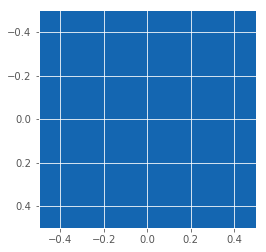

In [291]:
rust_patches_hsv = get_patches(convert_colorspace(rust_element, 'rgb', 'hsv'), patch_size = 1)
rust_mean = np.median(rust_patches_hsv, axis = (0))
plt.imshow(np.reshape(rust_mean, newshape = [1, 1, 3]));

*Covariance*

In [554]:
rust_covar = np.cov(rust_patches_hsv, rowvar = False)*5

In [555]:
from scipy.stats import multivariate_normal

In [556]:
# Get image patches
image_patches = get_patches(hsv_image, patch_size = 1)

# Evaluate proximity to patch mean/covar
pred = multivariate_normal.pdf(image_patches, rust_mean, rust_covar)/pred.max()

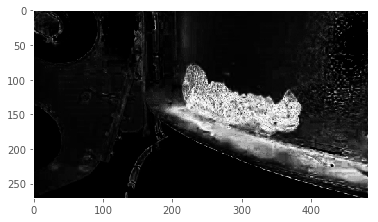

In [557]:
plt.imshow(np.reshape(pred, [271, 483]), cmap = 'gray')
plt.grid('off')

### Frequency filtering

In [509]:
from numpy.fft import fft2, fftshift, ifftshift, ifft2

In [533]:
lightness  = hsv_image[:,:,2]
flightness = fft2(lightness)
fshift     = fftshift(flightness)
wsize = 130
mask  = np.zeros_like(fshift).astype(bool)
mask[fshift.shape[0]//2 - wsize: fshift.shape[0]//2 + wsize,
     fshift.shape[1]//2 - wsize: fshift.shape[1]//2 + wsize] = True
fshift[mask] = 0
rlightness = np.abs(ifft2(ifftshift(fshift)))

(-0.5, 483.5, 271.5, -0.5)

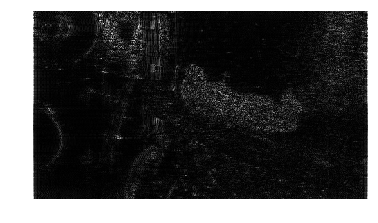

In [534]:
plt.imshow(rlightness, cmap = 'gray');
plt.axis('off')

In [535]:
rlightness = rlightness/rlightness.max()

In [558]:
pred = np.reshape(pred, [271, 483])/np.max(pred)

(-0.5, 483.5, 271.5, -0.5)

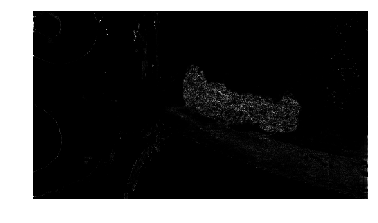

In [536]:
plt.imshow(rlightness*hue_filtered, cmap = 'gray')
plt.axis('off')

(-0.5, 482.5, 270.5, -0.5)

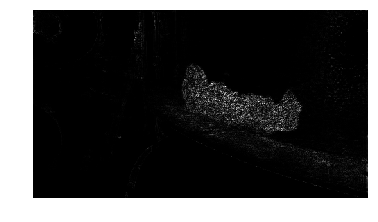

In [559]:
plt.imshow(rlightness[1:,:-1]*pred, cmap = 'gray')
plt.axis('off')

### Bespoke model

In [537]:
#b_input = rlightness*hue_filtered

In [560]:
b_input = rlightness[1:,:-1]*pred

In [566]:
b_c = convolutional_softmax_classifier(3, in_channels = 1, learning_rate = 1)

with tf.Session(graph = b_c.graph) as session:
    session.run(tf.global_variables_initializer())
    fd        = {b_c.input_image : b_input[np.newaxis, :, :, np.newaxis],
                 b_c.input_mask  : raw_mask[np.newaxis, 1:, :-1] }
    
    for step in range(training_steps):
        _, l = session.run([b_c.optimize, b_c.loss], feed_dict = fd)
        if step % 500 == 0:
            print('Loss at step {:^3d}: {:^5.2f}'.format(step, l))
            
    p_b = session.run(b_c.predictions, feed_dict = fd)

Loss at step  0 : 1.02 
Loss at step 500: 0.16 
Loss at step 1000: 0.14 
Loss at step 1500: 0.12 
Loss at step 2000: 0.12 
Loss at step 2500: 0.11 
Loss at step 3000: 0.11 
Loss at step 3500: 0.10 
Loss at step 4000: 0.10 
Loss at step 4500: 0.10 
Loss at step 5000: 0.10 


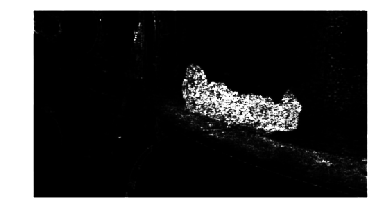

In [567]:
plt.imshow(p_b[0,:,:,0], cmap = 'gray')
plt.axis('off');

- Explain method (i.e. what is the FFT, what are we doing by filtering then applying the inverse fft)
- Demonstrate feature engineering rational (e.g. using hue in a convolutional neural network).
- Briefly summary purpose in modelling hsv/hue alone using a gaussian.
- Talk about properties of the problem:
    - Absence of directionality or periodicity
    - Constant hue
    - Variation is saturation, lightness
    - High-frequency property
    - Discuss why eigenfilters/Laws' filters did not work
